## Imports

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

from khan_helpers import Experiment, Participant
from khan_helpers.constants import FIG_DIR

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.helpers import show_source<br />    show_source(foo)</pre>

## Set plotting params

In [2]:
plt.rcParams['pdf.fonttype'] = 42
sns.set_context('talk')
sns.set_style('white')
cmap = 'rocket_r'

## Define functions

In [3]:
def fmt_stats(data, other=None):
    """computes and formats r- and p-values for display in heatmap"""
    if other is None:
        other = data
    cols = data.columns
    cols_other = other.columns
    stats = np.empty((len(cols), len(cols_other)), dtype=object)
    for x, colx in enumerate(cols_other):
        for y, coly in enumerate(cols):
            r, p = pearsonr(other[colx], data[coly])
            r = f'= {r:.2f}'
            if p < 0.01:
                p = '< 0.01'
            else:
                p = f'= {p:.2f}'
            stats[x, y] = f'r {r}\np {p}'
    return stats

## Load & format data

In [4]:
exp = Experiment()
participants = exp.load_participants()

In [5]:
pix = pd.IndexSlice

prop_correct = pd.DataFrame(
    index=pd.MultiIndex.from_product((
        (f'qset{i}' for i in range(1, 4)), 
        (str(p) for p in participants))),
    columns=('General\nknowledge', 'Four\nForces', 'Birth of\nStars'),
    dtype=np.float
)

for p in participants:
    p_data = p.get_data()
    acc_grp = p_data.groupby(['lecture', 'qset'])['accuracy']
    p_acc = acc_grp.agg(lambda x: x.sum() / x.shape[0])
    prop_correct.loc[pix[:, str(p)], :] = p_acc.values.reshape(3, 3).T
    
prop_correct = prop_correct.reindex(
    columns=['General\nknowledge', 'Birth of\nStars', 'Four\nForces']
)
prop_correct.head()

General\nknowledge  Birth of\nStars  Four\nForces
qset1 P1            0.333333              0.6           0.6
      P2            0.333333              0.2           0.2
      P3            0.333333              0.2           0.6
      P4            0.666667              0.4           0.4
      P5            0.333333              0.4           0.2

## Relationships among proportion correct measures

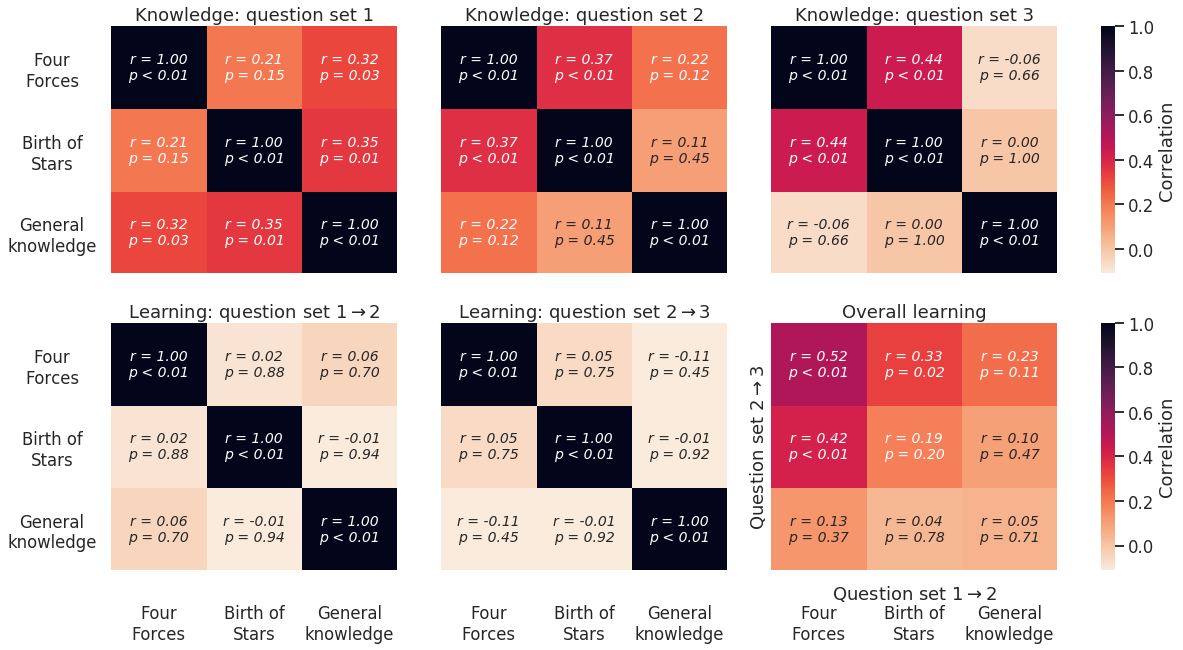

In [6]:
fig, axarr = plt.subplots(2, 4, figsize=(18, 10), 
                         gridspec_kw={'width_ratios': (1, 1, 1, .05)})
axarr, (cax1, cax2) = axarr[:, :3], axarr[:, 3]
cbar_kws = {'label': 'Correlation'}

for qset, ax in enumerate(axarr[0], start=1):
    cbar = True if qset == 3 else False
    cbar_ax = cax1 if cbar else None
    ckws = cbar_kws if cbar else None
    data = prop_correct.loc[f'qset{qset}']
    stats = fmt_stats(data)
    sns.heatmap(data.corr(), vmin=-.11, vmax=1, cmap=cmap, cbar=cbar, 
                cbar_ax=cbar_ax, cbar_kws=ckws, annot=stats, fmt='', 
                annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
    ax.set_title(f'Knowledge: question set {qset}')
    if qset == 1:
        ax.set_xticklabels([])
        ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
        ax.tick_params(axis='y', direction='out', pad=50)
    else:
        ax.axis('off')
    
for qset, ax in enumerate(axarr[1, :2], start=1):
    data = prop_correct.loc[f'qset{qset + 1}'] - prop_correct.loc[f'qset{qset}']
    stats = fmt_stats(data)
    sns.heatmap(data.corr(), vmin=0, vmax=1, cmap=cmap, cbar=False, annot=stats,
                fmt='', annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
    ax.set_title(rf'Learning: question set {qset}$\rightarrow${qset + 1}')
    if qset == 1:
        ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
        ax.tick_params(axis='y', direction='out', pad=50)
    else:
        ax.set_yticklabels([])
    
ax = axarr[1, 2]
d1 = prop_correct.loc['qset2']
d2 = prop_correct.loc['qset3']
data = d1.apply(lambda x: d2.corrwith(x))
stats = fmt_stats(d1, d2)
sns.heatmap(data, vmin=-.11, vmax=1, cmap=cmap, cbar=True, cbar_ax=cax2, 
            cbar_kws=cbar_kws, annot=stats, fmt='', 
            annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
ax.set_title('Overall learning')
ax.set_xlabel(r'Question set 1$\rightarrow$2', labelpad=-60)
ax.set_ylabel(r'Question set 2$\rightarrow$3', labelpad=-10)
ax.set_yticklabels([])

# doesn't work if called in loops above... very weird ¯\_(ツ)_/¯
for ax in axarr.flatten():
    ax.invert_xaxis()
    ax.invert_yaxis()
for ax in axarr[1]:
    ax.tick_params(axis='x', pad=25)

# plt.savefig(FIG_DIR.joinpath('prop-correct-relationships.pdf'), bbox_inches='tight')
plt.show()

## Relationships between novel measures

In [9]:
# # Not really useful...
# pix = pd.IndexSlice

# mean_traces = pd.DataFrame(
#     index=prop_correct.index,
#     columns=('Four\nForces', 'Birth of\nStars'),
#     dtype=np.float
# )

# col_map = {'forces': 'Four\nForces', 'bos':'Birth of\nStars'}
# for p in participants:
#     for lecture in ('forces', 'bos'):
#         for qset in range(3):
#             p_trace = p.get_trace(f'{lecture}_qset{qset}')
#             mean_traces.loc[
#                 (f'qset{qset + 1}', str(p)), col_map[lecture]
#             ] = p_trace.mean()
    
# mean_traces = mean_traces.reindex(columns=['Birth of\nStars', 'Four\nForces'])
# mean_traces.head()

In [10]:
# # Not really useful...
# fig, axes = plt.subplots(2, 4, figsize=(18, 10), 
#                          gridspec_kw={'width_ratios': (1, 1, 1, .05)})
# axarr, (cax1, cax2) = axes[:, :3], axes[:, 3]
# cbar_kws = {'label': 'Correlation'}

# for qset, ax in enumerate(axarr[0], start=1):
#     cbar = True if qset == 3 else False
#     cbar_ax = cax1 if cbar else None
#     ckws = cbar_kws if cbar else None
#     data = mean_traces.loc[f'qset{qset}']
#     stats = fmt_stats(data)
#     sns.heatmap(data.corr(), vmin=0, vmax=1, cmap=cmap, cbar=cbar, 
#                 cbar_ax=cbar_ax, cbar_kws=ckws, annot=stats, fmt='', 
#                 annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
#     ax.set_title(f'Reconstructed knowledge:\nquestion set {qset}')
#     if qset == 1:
#         ax.set_xticklabels([])
#         ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
#         ax.tick_params(axis='y', direction='out', pad=50)
#     else:
#         ax.axis('off')
    
# for qset, ax in enumerate(axarr[1, :2], start=1):
#     data = mean_traces.loc[f'qset{qset + 1}'] - mean_traces.loc[f'qset{qset}']
#     stats = fmt_stats(data)
#     sns.heatmap(data.corr(), vmin=0, vmax=1, cmap=cmap, cbar=False, annot=stats,
#                 fmt='', annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
#     ax.set_title('Reconstructed learning:\n' + 
#                  rf'question set {qset}$\rightarrow${qset + 1}')
#     if qset == 1:
#         ax.set_yticklabels(labels=ax.get_yticklabels(), ha='center', ma='center')
#         ax.tick_params(axis='y', direction='out', pad=50)
#     else:
#         ax.set_yticklabels([])
    
# ax = axarr[1, 2]
# d1 = mean_traces.loc['qset2']
# d2 = mean_traces.loc['qset3']
# data = d1.apply(lambda x: d2.corrwith(x))
# stats = fmt_stats(d1, d2)
# sns.heatmap(data, vmin=0, vmax=1, cmap=cmap, cbar=True, cbar_ax=cax2, 
#             cbar_kws=cbar_kws, annot=stats, fmt='', 
#             annot_kws={'size': 14, 'style': 'italic'}, ax=ax)
# ax.set_title('Overall reconstructed learning')
# ax.set_xlabel(r'Question set 1$\rightarrow$2', labelpad=-60)
# ax.set_ylabel(r'Question set 2$\rightarrow$3', labelpad=-10)
# ax.set_yticklabels([])

# # doesn't work if called in loops above... very weird ¯\_(ツ)_/¯
# for ax in axarr.flatten():
#     ax.invert_xaxis()
#     ax.invert_yaxis()
# for ax in axarr[1]:
#     ax.tick_params(axis='x', pad=25)

# # plt.savefig(FIG_DIR.joinpath('prop-correct-relationships.pdf'), bbox_inches='tight')
# plt.show()